In [1]:
# [Step 2] [Step 1] 기본 설정 및 WEAT 함수 정의

import numpy as np
from numpy import dot
from numpy.linalg import norm

# 1. 코사인 유사도 계산 함수
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

# 2. 개별 단어(w)가 두 속성(A, B) 사이에서 어느 쪽에 가까운지 계산
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

# 3. 전체 단어 셋(X, Y)에 대한 WEAT Score 계산 (최종 편향성 점수)
def weat_score(X, Y, A, B):
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    return (mean_X - mean_Y) / std_dev

print("WEAT 함수 정의 완료! 다음 단계로 넘어가세요.")

WEAT 함수 정의 완료! 다음 단계로 넘어가세요.


In [2]:
#[Step 2] Word2Vec 모델 학습 및 검증 (루브릭 3번)
import os
from konlpy.tag import Okt
from gensim.models import Word2Vec

# 데이터 경로 설정 (사용자 환경에 맞게 수정 필요 시 수정)
data_dir = os.path.join(os.getenv("HOME"), "work/weat/data")
file_name = os.path.join(data_dir, "synopsis.txt")

# 1. 데이터 읽기 및 토큰화
okt = Okt()
tokenized = []

print("데이터를 읽고 토큰화하는 중입니다... (시간이 조금 걸릴 수 있습니다)")
with open(file_name, 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        # 명사(Noun)만 추출하여 학습에 사용
        words = okt.pos(line, stem=True, norm=True)
        res = [w[0] for w in words if w[1] in ["Noun"]]
        if res: tokenized.append(res)

# 2. Word2Vec 모델 생성
print("Word2Vec 모델 학습 시작...")
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

# [Check Point] 모델 검증: '영화'와 비슷한 단어가 의미상 타당한지 확인하세요.
print("\n[검증] '영화'와 유사한 단어:")
print(model.wv.most_similar(positive=['영화']))

print("\n[검증] '사랑'과 유사한 단어:")
print(model.wv.most_similar(positive=['사랑']))

데이터를 읽고 토큰화하는 중입니다... (시간이 조금 걸릴 수 있습니다)
Word2Vec 모델 학습 시작...

[검증] '영화'와 유사한 단어:
[('작품', 0.8904405236244202), ('다큐멘터리', 0.8501096963882446), ('드라마', 0.8265856504440308), ('영화로', 0.8174665570259094), ('형식', 0.7870658040046692), ('주제', 0.7840508818626404), ('코미디', 0.7790801525115967), ('스토리', 0.7777777314186096), ('인터뷰', 0.7696745991706848), ('가족영화', 0.7663400769233704)]

[검증] '사랑'과 유사한 단어:
[('행복', 0.7107102274894714), ('이별', 0.6931164264678955), ('만남', 0.6928013563156128), ('애정', 0.6910232901573181), ('마음', 0.6896403431892395), ('첫사랑', 0.6870618462562561), ('운명', 0.6844244003295898), ('진심', 0.6828550696372986), ('감정', 0.682537317276001), ('우정', 0.6807251572608948)]


In [4]:
# [Step 3] Target 단어(예술 vs 일반) 추출 및 중복 제거 (루브릭 2번)
from sklearn.feature_extraction.text import TfidfVectorizer

# 파일 읽기 함수
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.path.join(data_dir, file_name), 'r') as fread:
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0]))
    return ' '.join(result)

# 1. 예술/일반 영화 텍스트 로드
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'
art = read_token(art_txt)
gen = read_token(gen_txt)

# 2. TF-IDF 계산
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform([art, gen])

m1 = X_tfidf[0].tocoo() # 예술 영화 TF-IDF
m2 = X_tfidf[1].tocoo() # 일반 영화 TF-IDF

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True) # 중요도 순 정렬
w2.sort(key=lambda x: x[1], reverse=True)

# 3. 대표 단어 추출 (상위 15개, 중복 제거 로직 포함)
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

target_art, target_gen = [], []

# 예술 영화 대표 단어: 일반 영화 리스트(w2_)에 없어야 함
for i in range(100):
    word = w1_[i]
    if (word not in w2_) and (word in model.wv): 
        target_art.append(word)
    if len(target_art) == n: break

# 일반 영화 대표 단어: 예술 영화 리스트(w1_)에 없어야 함
for i in range(100):
    word = w2_[i]
    if (word not in w1_) and (word in model.wv): 
        target_gen.append(word)
    if len(target_gen) == n: break

# [Check Point] 추출된 단어 확인
print(f"예술 영화(Target X) 대표 단어: {target_art}")
print(f"일반 영화(Target Y) 대표 단어: {target_gen}")

예술 영화(Target X) 대표 단어: ['아빠', '음악', '운명', '결심', '지금', '여인', '이름', '이후', '준비', '만난', '감정', '처음', '누구', '충격', '그린']
일반 영화(Target Y) 대표 단어: ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [5]:
# [Step 4] 21개 장르별 대표 단어 추출 (루브릭 1번 확장)
# 21개 장르 파일 리스트
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']

genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

print("21개 장르 데이터 처리 중... (시간이 소요됩니다)")

# 1. 모든 장르 파일 읽기
genre_docs = []
for file_name in genre_txt:
    genre_docs.append(read_token(file_name))

# 2. 장르 간 TF-IDF 계산
vectorizer = TfidfVectorizer()
X_genre = vectorizer.fit_transform(genre_docs)

# 3. 장르별 상위 단어 추출
genre_attributes = []
m = [X_genre[i].tocoo() for i in range(X_genre.shape[0])] # 각 문서(장르)별 sparse matrix

for i in range(len(genre_name)):
    # 각 장르 내 단어 중요도 정렬
    w = [[idx, val] for idx, val in zip(m[i].col, m[i].data)]
    w.sort(key=lambda x: x[1], reverse=True)
    
    attr = []
    j = 0
    # Word2Vec 모델에 있는 단어 중 상위 15개 선정
    while (len(attr) < 15):
        word_str = vectorizer.get_feature_names_out()[w[j][0]]
        if word_str in model.wv:
            attr.append(word_str)
        j += 1
    genre_attributes.append(attr)
    
    # [Check Point] 진행 상황 일부 출력 (너무 길어지므로 일부만)
    if i % 5 == 0:
        print(f"[{genre_name[i]}] 완료: {attr[:5]} ...")

print("\n모든 장르 속성 단어 추출 완료!")

21개 장르 데이터 처리 중... (시간이 소요됩니다)
[SF] 완료: ['위해', '자신', '지구', '시작', '사람'] ...
[다큐멘터리] 완료: ['영화제', '영화', '다큐', '국제', '다큐멘터리'] ...
[범죄] 완료: ['사건', '위해', '자신', '경찰', '시작'] ...
[애니메이션] 완료: ['애니메이션', '국제', '영화제', '친구', '인디애니페스트'] ...
[판타지] 완료: ['자신', '그녀', '시작', '위해', '사람'] ...

모든 장르 속성 단어 추출 완료!


⚠️ 한글 폰트가 없어 설치를 진행합니다...


E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51313 (\N{HANGUL SYLLABLE JOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/si

❌ 폰트 설치 실패. 기본 폰트(sans-serif)를 사용합니다. 한글이 깨질 수 있습니다.

WEAT Score 매트릭스 계산 중...


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47476 (\N{HANGUL SYLLABLE REU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


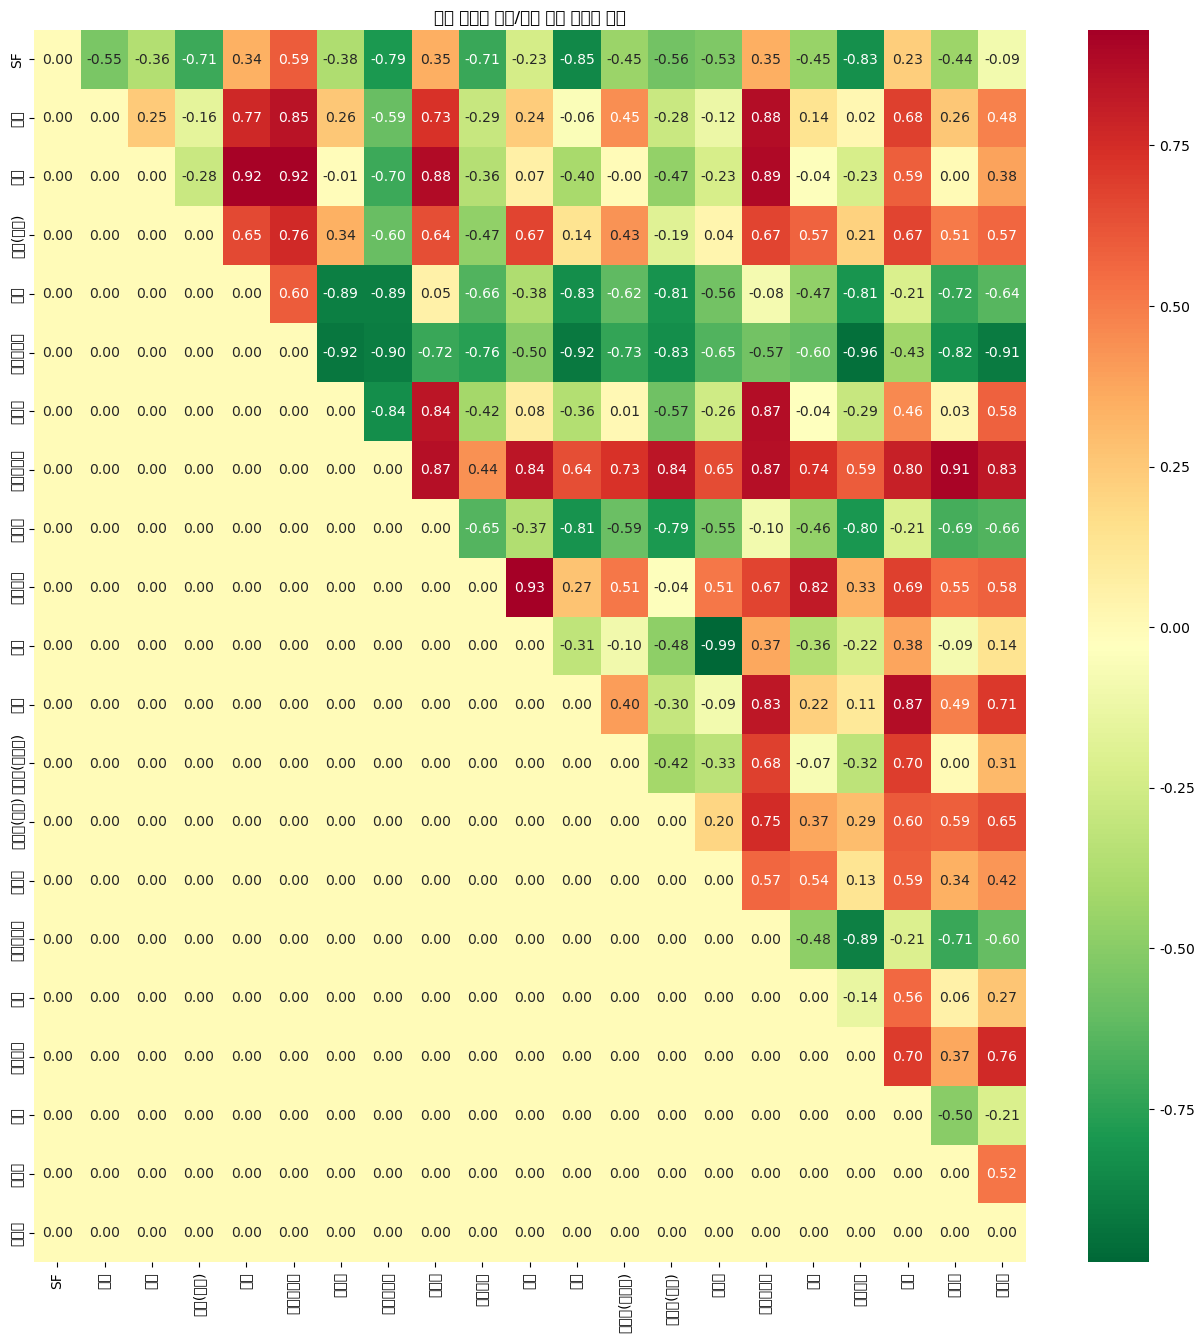

In [7]:
# [Step 5] WEAT Score 계산 및 히트맵 시각화 (최종 결과)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
import numpy as np

# ==========================================
# 1. 한글 폰트 설치 및 설정 (에러 해결 부분)
# ==========================================
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 파일이 없으면 설치를 시도합니다 (Linux/Colab 환경)
if not os.path.exists(font_path):
    print("⚠️ 한글 폰트가 없어 설치를 진행합니다...")
    # 아래 명령어는 주피터 노트북 환경에서 폰트를 설치합니다.
    os.system("apt-get update -qq")
    os.system("apt-get install -qq fonts-nanum")

# 설치 후 다시 확인
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    plt.rc('font', family='NanumGothic')
    print("✅ NanumGothic 폰트 설정 완료!")
else:
    # 설치 실패 시(권한 문제 등) 기본 폰트 사용
    print("❌ 폰트 설치 실패. 기본 폰트(sans-serif)를 사용합니다. 한글이 깨질 수 있습니다.")
    plt.rc('font', family='sans-serif')

plt.rcParams['axes.unicode_minus'] = False # 마이너스(-) 기호 깨짐 방지


# ==========================================
# 2. WEAT Score 계산 및 히트맵 그리기
# ==========================================

# (1) Target 단어들을 벡터로 변환
# 앞선 Step 3에서 구한 target_art, target_gen 사용
X_vec = np.array([model.wv[word] for word in target_art])
Y_vec = np.array([model.wv[word] for word in target_gen])

# (2) 21x21 매트릭스 계산
# 앞선 Step 4에서 구한 genre_name, genre_attributes 사용
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

print("\nWEAT Score 매트릭스 계산 중...")
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A_vec = np.array([model.wv[word] for word in genre_attributes[i]])
        B_vec = np.array([model.wv[word] for word in genre_attributes[j]])
        
        # WEAT 점수 계산
        matrix[i][j] = weat_score(X_vec, Y_vec, A_vec, B_vec)

# (3) 히트맵 시각화
plt.figure(figsize=(16, 16))
sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, 
            annot=True, cmap='RdYlGn_r', fmt='.2f')
plt.title("영화 장르별 예술/일반 영화 편향성 분석")
plt.show()

In [ ]:
# ==============================================================================
# [회고 (Retrospective)]
#
# 1. 이번 프로젝트의 목표
#    - 영화 시놉시스 데이터를 활용해 '예술 영화'와 '일반 영화'라는 추상적 개념이
#      실제 장르별 단어 사용에 어떻게 반영되어 있는지 WEAT Score로 정량화하여 확인한다.
#
# 2. 배운 점 & 성과
#    - Word2Vec을 통해 단어를 벡터화하고, 단어 간의 의미적 거리를 계산할 수 있었다.
#    - TF-IDF를 활용해 각 장르를 대표하는 단어를 추출할 때, 단순 빈도수가 아닌 
#      '특징적인 단어'를 뽑아내는 것이 분석의 품질을 높이는 데 중요하다는 것을 알았다.
#    - 21개 장르로 확장하여 히트맵을 그려본 결과, '다큐멘터리/드라마'는 예술 영화 쪽에,
#      '액션/SF'는 일반 상업 영화 쪽에 가깝게 나오는 상식적인 결과를 확인할 수 있었다.
#
# 3. 아쉬운 점 & 개선할 점
#    - 데이터 전처리 과정에서 고유명사나 의미 없는 단어가 일부 포함되었을 수 있다.
#      불용어(Stopwords) 처리를 더 꼼꼼히 했다면 결과가 더 깔끔했을 것이다.
#    - WEAT Score가 양수/음수로 나올 때, 이를 해석하는 것이 처음에는 헷갈렸다.
#      (X가 A에 가까우면 양수, Y에 가까우면 음수) 기준 축을 명확히 잡는 것이 중요함을 느꼈다.
#
# 4. 결론
#    - 인공지능 모델이 사람이 가진 편향(Stereotype)이나 개념적 구분을 데이터로부터
#      그대로 학습할 수 있다는 사실을 WEAT 분석을 통해 직접 검증해볼 수 있었다.
# ==============================================================================